# 1. Dataset 준비

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F     
import torch.optim as optim

from torch.utils.data import TensorDataset # 텐서 데이터셋
from torch.utils.data import DataLoader # 데이터로더

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

#csv이용을 위한 라이브러리들
import numpy as np
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset_path = 'model/keypoint_classifier/keypoint.csv'
coord_norm = np.loadtxt(train_dataset_path,delimiter=',',dtype='float32',usecols=list(range(1,(21*2)+1)))
label = np.loadtxt(train_dataset_path,delimiter=',',dtype='float32',usecols=(0))

coord_norm = torch.tensor(coord_norm).to(device)
label = torch.tensor(label).to(device)


# 2. Graph Convolution Network 설계

In [ ]:
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import add_self_loops

# GCN 설계
class HandGestureGCN(torch.nn.Module):
    def __init__(self, in_channels=2, hidden_channels=64, out_channels=10, depth=2):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for i in range(depth):
            if i == 0:
                self.convs.append(GCNConv(in_channels, hidden_channels))
            else:
                self.convs.append(GCNConv(hidden_channels, hidden_channels))

        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
        x = global_mean_pool(x, batch)  # [num_graphs, hidden_channels] (readout)
        return self.fc(x)

# 원래 data에서 GCN에 어울리는 data로 변환
def create_data_list(coord_tensor, label_tensor, edge_index):
    data_list = []
    for i in range(coord_tensor.size(0)):
        coords = coord_tensor[i].view(21, 2)  # [42] -> [21, 2]
        label = label_tensor[i].long()
        data = Data(x=coords, edge_index=edge_index, y=label)
        data_list.append(data)
    return data_list

# 3. Training

In [ ]:
'''
Data 생성
Node Feature: 21개의 keypoint 좌표 (x, y)
Edge Feature: 21개의 keypoint 간의 연결 (엄지, 검지, 중지, 약지, 소지)
Label: 손 제스처 클래스 (0~9)
'''

# 1. 원래 edge 정의
edges = [
    (0, 1), (1, 2), (2, 3), (3, 4), (0, 5),  # 엄지
    (5, 9), (5, 6), (6, 7), (7, 8),         # 검지
    (9, 13), (9, 10), (10, 11), (11, 12),   # 중지
    (13, 17), (13, 14), (14, 15), (15, 16), # 약지
    (0, 17), (17, 18), (18, 19), (19, 20)   # 소지
]

# 2. 양방향 처리
edges += [(j, i) for (i, j) in edges]

# 3. Tensor로 변환
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()  # shape: [2, num_edges]

# 4. self-loop 추가
edge_index, _ = add_self_loops(edge_index, num_nodes=21)

# 5. 데이터셋 생성
data_list = create_data_list(coord_norm, label, edge_index)

c:\Users\cvip\anaconda3\envs\dnn\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [39]:
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import os

# 1. 학습 환경
num_epochs = 100
learning_rate = 1e-3
batch_size = 32
model_depth = 2
hidden_channels = 64


# 2. 모델 초기화
model = HandGestureGCN(in_channels=2, hidden_channels=hidden_channels, out_channels=10, depth=model_depth).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

# 3. 데이터셋 분할
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

best_test_acc = 0.0
best_model_path = 'model/keypoint_classifier/gcn_checkpoints/best_model.pth'

# 4. Training loop
for epoch in range(1, num_epochs + 1):
    # 학습
    model.train()
    total_loss = 0 
    for batch in tqdm(train_loader, desc=f"[Epoch {epoch}/{num_epochs}] Training"):
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    total_loss /= len(train_loader.dataset)

    # 평가
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            pred = out.argmax(dim=1)
            preds.append(pred.cpu())
            targets.append(batch.y.cpu())
    
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    test_acc = accuracy_score(targets, preds)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
        torch.save(model.state_dict(), best_model_path)
    
    print(f"        Loss: {total_loss:.4f} | Test Acc: {test_acc:.4f} | Best: {best_test_acc:.4f}")

[Epoch 1/100] Training: 100%|██████████| 164/164 [00:01<00:00, 147.21it/s]


        Loss: 2.1382 | Test Acc: 0.2688 | Best: 0.2688


[Epoch 2/100] Training: 100%|██████████| 164/164 [00:00<00:00, 164.15it/s]


        Loss: 1.9343 | Test Acc: 0.3974 | Best: 0.3974


[Epoch 3/100] Training: 100%|██████████| 164/164 [00:00<00:00, 168.52it/s]


        Loss: 1.6978 | Test Acc: 0.4104 | Best: 0.4104


[Epoch 4/100] Training: 100%|██████████| 164/164 [00:01<00:00, 162.85it/s]


        Loss: 1.5727 | Test Acc: 0.4288 | Best: 0.4288


[Epoch 5/100] Training: 100%|██████████| 164/164 [00:00<00:00, 172.18it/s]


        Loss: 1.4954 | Test Acc: 0.4288 | Best: 0.4288


[Epoch 6/100] Training: 100%|██████████| 164/164 [00:01<00:00, 162.72it/s]


        Loss: 1.4329 | Test Acc: 0.4510 | Best: 0.4510


[Epoch 7/100] Training: 100%|██████████| 164/164 [00:00<00:00, 164.69it/s]


        Loss: 1.3940 | Test Acc: 0.4686 | Best: 0.4686


[Epoch 8/100] Training: 100%|██████████| 164/164 [00:00<00:00, 172.03it/s]


        Loss: 1.3609 | Test Acc: 0.4885 | Best: 0.4885


[Epoch 9/100] Training: 100%|██████████| 164/164 [00:01<00:00, 162.38it/s]


        Loss: 1.3257 | Test Acc: 0.5138 | Best: 0.5138


[Epoch 10/100] Training: 100%|██████████| 164/164 [00:00<00:00, 168.84it/s]


        Loss: 1.3060 | Test Acc: 0.5092 | Best: 0.5138


[Epoch 11/100] Training: 100%|██████████| 164/164 [00:00<00:00, 164.33it/s]


        Loss: 1.2876 | Test Acc: 0.5230 | Best: 0.5230


[Epoch 12/100] Training: 100%|██████████| 164/164 [00:01<00:00, 155.01it/s]


        Loss: 1.2633 | Test Acc: 0.5360 | Best: 0.5360


[Epoch 13/100] Training: 100%|██████████| 164/164 [00:01<00:00, 156.06it/s]


        Loss: 1.2432 | Test Acc: 0.5697 | Best: 0.5697


[Epoch 14/100] Training: 100%|██████████| 164/164 [00:00<00:00, 174.13it/s]


        Loss: 1.2257 | Test Acc: 0.5789 | Best: 0.5789


[Epoch 15/100] Training: 100%|██████████| 164/164 [00:01<00:00, 162.82it/s]


        Loss: 1.2065 | Test Acc: 0.5934 | Best: 0.5934


[Epoch 16/100] Training: 100%|██████████| 164/164 [00:01<00:00, 163.18it/s]


        Loss: 1.1859 | Test Acc: 0.5995 | Best: 0.5995


[Epoch 17/100] Training: 100%|██████████| 164/164 [00:01<00:00, 163.57it/s]


        Loss: 1.1713 | Test Acc: 0.5934 | Best: 0.5995


[Epoch 18/100] Training: 100%|██████████| 164/164 [00:00<00:00, 175.31it/s]


        Loss: 1.1520 | Test Acc: 0.5804 | Best: 0.5995


[Epoch 19/100] Training: 100%|██████████| 164/164 [00:00<00:00, 165.82it/s]


        Loss: 1.1316 | Test Acc: 0.6340 | Best: 0.6340


[Epoch 20/100] Training: 100%|██████████| 164/164 [00:01<00:00, 159.22it/s]


        Loss: 1.1149 | Test Acc: 0.6225 | Best: 0.6340


[Epoch 21/100] Training: 100%|██████████| 164/164 [00:00<00:00, 170.83it/s]


        Loss: 1.0977 | Test Acc: 0.6616 | Best: 0.6616


[Epoch 22/100] Training: 100%|██████████| 164/164 [00:00<00:00, 169.56it/s]


        Loss: 1.0834 | Test Acc: 0.6194 | Best: 0.6616


[Epoch 23/100] Training: 100%|██████████| 164/164 [00:01<00:00, 163.03it/s]


        Loss: 1.0681 | Test Acc: 0.6554 | Best: 0.6616


[Epoch 24/100] Training: 100%|██████████| 164/164 [00:00<00:00, 171.61it/s]


        Loss: 1.0494 | Test Acc: 0.6493 | Best: 0.6616


[Epoch 25/100] Training: 100%|██████████| 164/164 [00:01<00:00, 159.84it/s]


        Loss: 1.0350 | Test Acc: 0.6654 | Best: 0.6654


[Epoch 26/100] Training: 100%|██████████| 164/164 [00:00<00:00, 172.17it/s]


        Loss: 1.0250 | Test Acc: 0.6470 | Best: 0.6654


[Epoch 27/100] Training: 100%|██████████| 164/164 [00:00<00:00, 169.60it/s]


        Loss: 1.0088 | Test Acc: 0.6907 | Best: 0.6907


[Epoch 28/100] Training: 100%|██████████| 164/164 [00:01<00:00, 162.19it/s]


        Loss: 1.0000 | Test Acc: 0.6455 | Best: 0.6907


[Epoch 29/100] Training: 100%|██████████| 164/164 [00:00<00:00, 175.42it/s]


        Loss: 0.9881 | Test Acc: 0.6700 | Best: 0.6907


[Epoch 30/100] Training: 100%|██████████| 164/164 [00:00<00:00, 164.90it/s]


        Loss: 0.9774 | Test Acc: 0.6884 | Best: 0.6907


[Epoch 31/100] Training: 100%|██████████| 164/164 [00:00<00:00, 171.81it/s]


        Loss: 0.9657 | Test Acc: 0.6639 | Best: 0.6907


[Epoch 32/100] Training: 100%|██████████| 164/164 [00:00<00:00, 170.76it/s]


        Loss: 0.9547 | Test Acc: 0.6700 | Best: 0.6907


[Epoch 33/100] Training: 100%|██████████| 164/164 [00:01<00:00, 149.38it/s]


        Loss: 0.9461 | Test Acc: 0.6761 | Best: 0.6907


[Epoch 34/100] Training: 100%|██████████| 164/164 [00:00<00:00, 173.54it/s]


        Loss: 0.9355 | Test Acc: 0.7205 | Best: 0.7205


[Epoch 35/100] Training: 100%|██████████| 164/164 [00:00<00:00, 165.29it/s]


        Loss: 0.9280 | Test Acc: 0.6761 | Best: 0.7205


[Epoch 36/100] Training: 100%|██████████| 164/164 [00:00<00:00, 164.33it/s]


        Loss: 0.9157 | Test Acc: 0.6815 | Best: 0.7205


[Epoch 37/100] Training: 100%|██████████| 164/164 [00:01<00:00, 159.22it/s]


        Loss: 0.9109 | Test Acc: 0.6983 | Best: 0.7205


[Epoch 38/100] Training: 100%|██████████| 164/164 [00:01<00:00, 155.01it/s]


        Loss: 0.9018 | Test Acc: 0.7121 | Best: 0.7205


[Epoch 39/100] Training: 100%|██████████| 164/164 [00:00<00:00, 169.25it/s]


        Loss: 0.8984 | Test Acc: 0.6761 | Best: 0.7205


[Epoch 40/100] Training: 100%|██████████| 164/164 [00:00<00:00, 166.78it/s]


        Loss: 0.8868 | Test Acc: 0.6715 | Best: 0.7205


[Epoch 41/100] Training: 100%|██████████| 164/164 [00:01<00:00, 163.30it/s]


        Loss: 0.8860 | Test Acc: 0.7075 | Best: 0.7205


[Epoch 42/100] Training: 100%|██████████| 164/164 [00:00<00:00, 165.90it/s]


        Loss: 0.8707 | Test Acc: 0.6922 | Best: 0.7205


[Epoch 43/100] Training: 100%|██████████| 164/164 [00:01<00:00, 161.86it/s]


        Loss: 0.8626 | Test Acc: 0.7243 | Best: 0.7243


[Epoch 44/100] Training: 100%|██████████| 164/164 [00:00<00:00, 172.85it/s]


        Loss: 0.8611 | Test Acc: 0.7320 | Best: 0.7320


[Epoch 45/100] Training: 100%|██████████| 164/164 [00:00<00:00, 167.84it/s]


        Loss: 0.8553 | Test Acc: 0.7175 | Best: 0.7320


[Epoch 46/100] Training: 100%|██████████| 164/164 [00:00<00:00, 172.06it/s]


        Loss: 0.8473 | Test Acc: 0.7121 | Best: 0.7320


[Epoch 47/100] Training: 100%|██████████| 164/164 [00:00<00:00, 168.72it/s]


        Loss: 0.8448 | Test Acc: 0.7136 | Best: 0.7320


[Epoch 48/100] Training: 100%|██████████| 164/164 [00:01<00:00, 161.82it/s]


        Loss: 0.8344 | Test Acc: 0.7044 | Best: 0.7320


[Epoch 49/100] Training: 100%|██████████| 164/164 [00:00<00:00, 169.61it/s]


        Loss: 0.8266 | Test Acc: 0.7312 | Best: 0.7320


[Epoch 50/100] Training: 100%|██████████| 164/164 [00:01<00:00, 150.87it/s]


        Loss: 0.8212 | Test Acc: 0.7182 | Best: 0.7320


[Epoch 51/100] Training: 100%|██████████| 164/164 [00:00<00:00, 171.00it/s]


        Loss: 0.8161 | Test Acc: 0.7129 | Best: 0.7320


[Epoch 52/100] Training: 100%|██████████| 164/164 [00:00<00:00, 169.46it/s]


        Loss: 0.8090 | Test Acc: 0.7511 | Best: 0.7511


[Epoch 53/100] Training: 100%|██████████| 164/164 [00:01<00:00, 160.78it/s]


        Loss: 0.8068 | Test Acc: 0.7412 | Best: 0.7511


[Epoch 54/100] Training: 100%|██████████| 164/164 [00:00<00:00, 172.69it/s]


        Loss: 0.7988 | Test Acc: 0.6715 | Best: 0.7511


[Epoch 55/100] Training: 100%|██████████| 164/164 [00:01<00:00, 161.09it/s]


        Loss: 0.7943 | Test Acc: 0.7328 | Best: 0.7511


[Epoch 56/100] Training: 100%|██████████| 164/164 [00:01<00:00, 163.75it/s]


        Loss: 0.7908 | Test Acc: 0.6937 | Best: 0.7511


[Epoch 57/100] Training: 100%|██████████| 164/164 [00:00<00:00, 172.89it/s]


        Loss: 0.7881 | Test Acc: 0.7205 | Best: 0.7511


[Epoch 58/100] Training: 100%|██████████| 164/164 [00:00<00:00, 165.99it/s]


        Loss: 0.7788 | Test Acc: 0.7052 | Best: 0.7511


[Epoch 59/100] Training: 100%|██████████| 164/164 [00:01<00:00, 156.19it/s]


        Loss: 0.7783 | Test Acc: 0.7450 | Best: 0.7511


[Epoch 60/100] Training: 100%|██████████| 164/164 [00:00<00:00, 167.69it/s]


        Loss: 0.7726 | Test Acc: 0.7213 | Best: 0.7511


[Epoch 61/100] Training: 100%|██████████| 164/164 [00:01<00:00, 161.56it/s]


        Loss: 0.7609 | Test Acc: 0.7381 | Best: 0.7511


[Epoch 62/100] Training: 100%|██████████| 164/164 [00:01<00:00, 161.15it/s]


        Loss: 0.7626 | Test Acc: 0.7106 | Best: 0.7511


[Epoch 63/100] Training: 100%|██████████| 164/164 [00:00<00:00, 168.71it/s]


        Loss: 0.7585 | Test Acc: 0.7243 | Best: 0.7511


[Epoch 64/100] Training: 100%|██████████| 164/164 [00:00<00:00, 167.34it/s]


        Loss: 0.7546 | Test Acc: 0.7320 | Best: 0.7511


[Epoch 65/100] Training: 100%|██████████| 164/164 [00:01<00:00, 156.33it/s]


        Loss: 0.7468 | Test Acc: 0.7014 | Best: 0.7511


[Epoch 66/100] Training: 100%|██████████| 164/164 [00:00<00:00, 168.64it/s]


        Loss: 0.7424 | Test Acc: 0.7450 | Best: 0.7511


[Epoch 67/100] Training: 100%|██████████| 164/164 [00:00<00:00, 168.98it/s]


        Loss: 0.7398 | Test Acc: 0.7312 | Best: 0.7511


[Epoch 68/100] Training: 100%|██████████| 164/164 [00:00<00:00, 164.19it/s]


        Loss: 0.7347 | Test Acc: 0.7734 | Best: 0.7734


[Epoch 69/100] Training: 100%|██████████| 164/164 [00:00<00:00, 169.66it/s]


        Loss: 0.7313 | Test Acc: 0.7381 | Best: 0.7734


[Epoch 70/100] Training: 100%|██████████| 164/164 [00:00<00:00, 164.82it/s]


        Loss: 0.7299 | Test Acc: 0.7312 | Best: 0.7734


[Epoch 71/100] Training: 100%|██████████| 164/164 [00:01<00:00, 163.83it/s]


        Loss: 0.7285 | Test Acc: 0.7596 | Best: 0.7734


[Epoch 72/100] Training: 100%|██████████| 164/164 [00:00<00:00, 166.83it/s]


        Loss: 0.7273 | Test Acc: 0.7389 | Best: 0.7734


[Epoch 73/100] Training: 100%|██████████| 164/164 [00:00<00:00, 167.16it/s]


        Loss: 0.7166 | Test Acc: 0.7343 | Best: 0.7734


[Epoch 74/100] Training: 100%|██████████| 164/164 [00:00<00:00, 169.43it/s]


        Loss: 0.7171 | Test Acc: 0.7420 | Best: 0.7734


[Epoch 75/100] Training: 100%|██████████| 164/164 [00:00<00:00, 169.27it/s]


        Loss: 0.7179 | Test Acc: 0.7734 | Best: 0.7734


[Epoch 76/100] Training: 100%|██████████| 164/164 [00:00<00:00, 167.52it/s]


        Loss: 0.7079 | Test Acc: 0.7573 | Best: 0.7734


[Epoch 77/100] Training: 100%|██████████| 164/164 [00:01<00:00, 153.37it/s]


        Loss: 0.7030 | Test Acc: 0.7511 | Best: 0.7734


[Epoch 78/100] Training: 100%|██████████| 164/164 [00:00<00:00, 168.39it/s]


        Loss: 0.7115 | Test Acc: 0.7902 | Best: 0.7902


[Epoch 79/100] Training: 100%|██████████| 164/164 [00:00<00:00, 167.34it/s]


        Loss: 0.7005 | Test Acc: 0.7665 | Best: 0.7902


[Epoch 80/100] Training: 100%|██████████| 164/164 [00:01<00:00, 160.00it/s]


        Loss: 0.6966 | Test Acc: 0.7741 | Best: 0.7902


[Epoch 81/100] Training: 100%|██████████| 164/164 [00:00<00:00, 171.72it/s]


        Loss: 0.6971 | Test Acc: 0.7519 | Best: 0.7902


[Epoch 82/100] Training: 100%|██████████| 164/164 [00:01<00:00, 161.85it/s]


        Loss: 0.6952 | Test Acc: 0.7879 | Best: 0.7902


[Epoch 83/100] Training: 100%|██████████| 164/164 [00:01<00:00, 156.18it/s]


        Loss: 0.6827 | Test Acc: 0.7818 | Best: 0.7902


[Epoch 84/100] Training: 100%|██████████| 164/164 [00:00<00:00, 172.43it/s]


        Loss: 0.6863 | Test Acc: 0.7588 | Best: 0.7902


[Epoch 85/100] Training: 100%|██████████| 164/164 [00:00<00:00, 167.86it/s]


        Loss: 0.6801 | Test Acc: 0.7779 | Best: 0.7902


[Epoch 86/100] Training: 100%|██████████| 164/164 [00:01<00:00, 154.28it/s]


        Loss: 0.6823 | Test Acc: 0.7511 | Best: 0.7902


[Epoch 87/100] Training: 100%|██████████| 164/164 [00:00<00:00, 168.55it/s]


        Loss: 0.6813 | Test Acc: 0.7672 | Best: 0.7902


[Epoch 88/100] Training: 100%|██████████| 164/164 [00:00<00:00, 165.82it/s]


        Loss: 0.6777 | Test Acc: 0.7887 | Best: 0.7902


[Epoch 89/100] Training: 100%|██████████| 164/164 [00:01<00:00, 161.26it/s]


        Loss: 0.6755 | Test Acc: 0.7833 | Best: 0.7902


[Epoch 90/100] Training: 100%|██████████| 164/164 [00:01<00:00, 161.01it/s]


        Loss: 0.6742 | Test Acc: 0.7818 | Best: 0.7902


[Epoch 91/100] Training: 100%|██████████| 164/164 [00:00<00:00, 167.87it/s]


        Loss: 0.6730 | Test Acc: 0.7757 | Best: 0.7902


[Epoch 92/100] Training: 100%|██████████| 164/164 [00:00<00:00, 166.16it/s]


        Loss: 0.6696 | Test Acc: 0.7818 | Best: 0.7902


[Epoch 93/100] Training: 100%|██████████| 164/164 [00:01<00:00, 155.79it/s]


        Loss: 0.6627 | Test Acc: 0.7994 | Best: 0.7994


[Epoch 94/100] Training: 100%|██████████| 164/164 [00:00<00:00, 166.55it/s]


        Loss: 0.6656 | Test Acc: 0.7818 | Best: 0.7994


[Epoch 95/100] Training: 100%|██████████| 164/164 [00:01<00:00, 158.91it/s]


        Loss: 0.6582 | Test Acc: 0.7841 | Best: 0.7994


[Epoch 96/100] Training: 100%|██████████| 164/164 [00:00<00:00, 176.53it/s]


        Loss: 0.6573 | Test Acc: 0.7810 | Best: 0.7994


[Epoch 97/100] Training: 100%|██████████| 164/164 [00:00<00:00, 169.95it/s]


        Loss: 0.6554 | Test Acc: 0.7726 | Best: 0.7994


[Epoch 98/100] Training: 100%|██████████| 164/164 [00:01<00:00, 162.53it/s]


        Loss: 0.6511 | Test Acc: 0.7925 | Best: 0.7994


[Epoch 99/100] Training: 100%|██████████| 164/164 [00:01<00:00, 160.94it/s]


        Loss: 0.6557 | Test Acc: 0.8032 | Best: 0.8032


[Epoch 100/100] Training: 100%|██████████| 164/164 [00:00<00:00, 169.08it/s]


        Loss: 0.6439 | Test Acc: 0.7757 | Best: 0.8032


# 3. Model test


Classification result
              precision    recall  f1-score   support

           0       0.54      0.79      0.64       301
           1       0.89      0.95      0.92       300
           2       0.32      0.82      0.46       300
           3       0.44      0.48      0.46       301
           4       0.64      0.61      0.62       300
           5       0.82      0.61      0.70       300
           6       0.69      0.60      0.64       299
           7       0.66      0.33      0.44       324
           8       0.80      0.49      0.60       290
           9       0.86      0.14      0.24       306

    accuracy                           0.58      3021
   macro avg       0.66      0.58      0.57      3021
weighted avg       0.66      0.58      0.57      3021



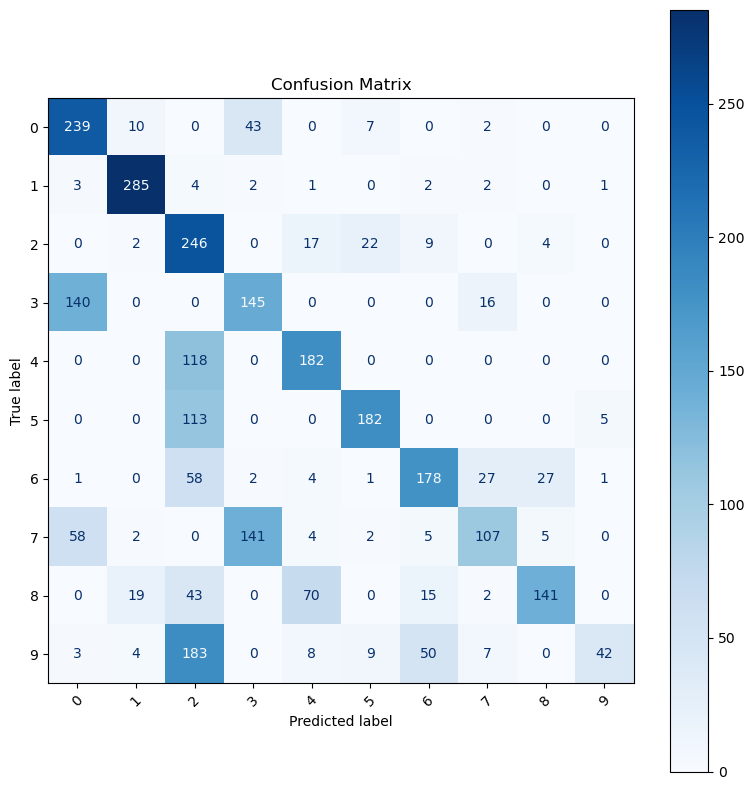

In [40]:
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. test data 로드
test_dataset_path = 'model/keypoint_classifier/test_keypoint.csv'
test_coords = np.loadtxt(test_dataset_path, delimiter=',', dtype='float32', usecols=range(1, 43))
test_labels = np.loadtxt(test_dataset_path, delimiter=',', dtype='float32', usecols=0)

test_coords = torch.tensor(test_coords)
test_labels = torch.tensor(test_labels)

# 2. edge_index 정의 (train과 동일)
edges = [
    (0, 1), (1, 2), (2, 3), (3, 4), (0, 5),
    (5, 9), (5, 6), (6, 7), (7, 8),
    (9, 13), (9, 10), (10, 11), (11, 12),
    (13, 17), (13, 14), (14, 15), (15, 16),
    (0, 17), (17, 18), (18, 19), (19, 20)
]
edges += [(j, i) for (i, j) in edges]

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
from torch_geometric.utils import add_self_loops
edge_index, _ = add_self_loops(edge_index, num_nodes=21)

# 3. Data 리스트 생성
def create_data_list(coord_tensor, label_tensor, edge_index):
    data_list = []
    for i in range(coord_tensor.size(0)):
        coords = coord_tensor[i].view(21, 2)
        label = label_tensor[i].long()
        data = Data(x=coords, edge_index=edge_index, y=label)
        data_list.append(data)
    return data_list

test_data_list = create_data_list(test_coords, test_labels, edge_index)
test_loader = DataLoader(test_data_list, batch_size=32, shuffle=False)

# 4. 모델 정의 (같은 구조로)
class HandGestureGCN(torch.nn.Module):
    def __init__(self, in_channels=2, hidden_channels=64, out_channels=10, depth=2):
        super().__init__()
        from torch_geometric.nn import GCNConv, global_mean_pool
        self.convs = torch.nn.ModuleList()
        for i in range(depth):
            self.convs.append(GCNConv(in_channels if i == 0 else hidden_channels, hidden_channels))
        self.fc = torch.nn.Linear(hidden_channels, out_channels)
        self.pool = global_mean_pool

    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = torch.relu(x)
        x = self.pool(x, batch)
        return self.fc(x)

# 5. 모델 로딩 및 평가
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HandGestureGCN().to(device)
model.load_state_dict(torch.load('model/keypoint_classifier/gcn_checkpoints/best_model.pth'))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        pred = out.argmax(dim=1)
        all_preds.append(pred.cpu())
        all_labels.append(batch.y.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# 6. Classification Report
print("\nClassification result")
print(classification_report(all_labels, all_preds, digits=2))

# 7. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
